In [1]:
import scipy
import re
import os
import datetime
import sklearn
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

from glob import glob
from missingno import matrix

from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.linear_model import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.data import Dataset

from numpy.lib.stride_tricks import sliding_window_view

os.environ["WANDB_SILENT"] = "True"
wandb.login()


True

In [2]:
# Radar data
df_NWP = np.load('./df_NWP',allow_pickle=True)

# other variables
df_temperature =  pd.read_pickle('../Rainfall - runoff/temperature_data.pkl')
df_temperature = df_temperature.rename(lambda x : str(x) + '_T',axis=1)

# Drainage flow data
df_target = pd.read_pickle('../Drainage data/all_drainage_data_uncorrected.pkl')
df_target = df_target.drop(['MOS-HOL','KOP-HAB'],axis=1)


In [3]:
rolling_size = 24

Xr = df_NWP.copy().sort_index()
Xt = df_temperature.copy()
Xtr = Xt.rolling(rolling_size,1).mean().rename(lambda x : str(x) + f'_rolling{rolling_size}',axis=1)

X = pd.concat([Xr,Xtr],axis=1)
Y = df_target.copy()

X_test = X.loc[datetime.datetime(2020,1,1,0,0,0):]
Y_test = X.loc[datetime.datetime(2020,1,1,0,0,0):]
X = X.loc[:datetime.datetime(2020,1,1,0,0,0)]
Y = Y.loc[:datetime.datetime(2020,1,1,0,0,0)]

In [4]:
drainage_names = ['RVK-GEL','RVK-BOD']
temperature_name = '1475_T_rolling24'
nwp_variables = range(6700)

In [5]:
def sliding_window(a, window):
    from numpy.lib.stride_tricks import as_strided
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return as_strided(a, shape=shape, strides=strides)
    
def process_temperature_predictions(df_spa_raw: pd.DataFrame):        
        # Fix the datatypes if needed
        df_spa_raw.temperature = pd.to_numeric(df_spa_raw.temperature, errors = 'coerce')
        df_spa_raw.date_time = pd.to_datetime(df_spa_raw.date_time)
        df_spa_raw.value_date = pd.to_datetime(df_spa_raw.value_date)
        
        # Compute offset of prediction (in hours) for pivot table columns
        df_spa_raw.loc[:,'prediction_offset'] = (df_spa_raw.date_time - df_spa_raw.value_date)/ np.timedelta64(1, 'h')
        
        # Pivot table (columns: prediction offest, rows: prediction date, value: Predicted values)
        df_vedurspa_pivot = df_spa_raw.pivot_table(values='temperature',index = 'value_date', columns = 'prediction_offset')
        df_vedurspa_pivot = df_vedurspa_pivot.loc[:,df_vedurspa_pivot.columns[df_vedurspa_pivot.columns > 0]]
        df_vedurspa_pivot = df_vedurspa_pivot.sort_index()

        # Resample rows in case any are missing
        df_vedurspa_pivot = df_vedurspa_pivot.resample('1h').mean()

        # Interpolate along the rows (i.e. If there are values as 12 and 15, interpolate for 13 and 14)
        df_vedurspa_pivot_lin_int = df_vedurspa_pivot.interpolate('linear',limit_direction='backward',axis=1).astype('float32')

        # If an 'old' prediction exists for a given hour but a newer one doesn't exist, use the old one
        for ts in df_vedurspa_pivot_lin_int.index[1:]:
            # Finna hvaða gildi eru til í seinustu röð og núverandi
            last = ts - datetime.timedelta(hours=1)
            values_last = df_vedurspa_pivot_lin_int.loc[last]
            values_curr = df_vedurspa_pivot_lin_int.loc[ts]
            missing_last = values_last.isna()
            missing_curr = values_curr.isna()

            # Finna hvaða gildi er þar af leiðandi hægt að færa fram úr seinustu röð sem nýjasta gildið
            to_be_replaced_part = list(missing_curr.values[:-1] & ~(missing_last.values[1:]))
            to_be_replaced = np.concatenate((to_be_replaced_part,[False]))
            to_replace = np.concatenate(([False],to_be_replaced[:-1]))

            # Uppfæra gagnagrunn með seinasta spágildi sem til var fyrir hverja klukkustund
            df_vedurspa_pivot_lin_int.loc[ts,to_be_replaced] = df_vedurspa_pivot_lin_int.loc[last,to_replace].values
        
        return df_vedurspa_pivot_lin_int
    
def make_dataframe(
        input_data : pd.Series,
        window_1 : int, # Previous values
        window_2 : int, # Future values
        input_var : bool, # Previous or future
        curr_only : bool 
        ):
         
        # Then create a sliding window over these datapoints
        input_vals = input_data.values.ravel()
        
        slice_1 = sliding_window(input_vals,window_1 + window_2).squeeze()
        slice_2 = sliding_window(slice_1,window_1)
        
        if curr_only:
            return np.asarray(slice_2[:,0,-1])
        if input_var:
            return np.asarray(slice_2[:,0,:])
        else:
            return np.asarray(slice_2[:,:,-1])
        
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)
lag = 48
pred_dist = 60
Y_all = Y.loc[d_start:d_end,drainage_names]

threshold_dict = {'RVK-GEL':[0,100,200,300,400,600,800,1000],
              'RVK-BOD':[0,25,50,75,100,125,150,200]}
thresholds = np.array(list(threshold_dict.values()))

target1 = make_dataframe(Y_all.iloc[:,0],lag,pred_dist,False,False)[:,1:]
target_index1 = make_dataframe(Y_all.index,lag,pred_dist,False,True)
target2 = make_dataframe(Y_all.iloc[:,1],lag,pred_dist,False,False)[:,1:]
target_index2 = make_dataframe(Y_all.index,lag,pred_dist,False,True)
df_target1_future = pd.DataFrame(target1,index = target_index1,columns = range(1,pred_dist+1))
df_target2_future = pd.DataFrame(target2,index = target_index2,columns = range(1,pred_dist+1))


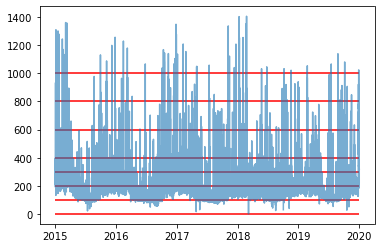

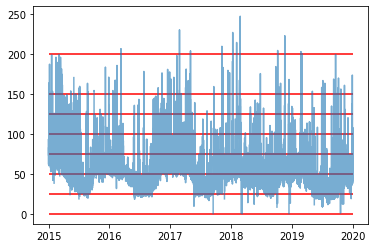

In [6]:
for sensor in threshold_dict:
    plt.plot(Y_all.loc[:,sensor],alpha = 0.6)
    plt.hlines(threshold_dict[sensor],Y_all.index.min(),Y_all.index.max(),color='red')
    plt.show()

# plt.plot(target2)
# plt.hlines(thresholds[1],0,800,color='red')
# plt.show()

In [73]:
URL_save_data = '../Experiments/Data/'
df_spa = pd.read_pickle(URL_save_data + 'temperature_forecast_data.pkl')
df_spa = df_spa.iloc[:,:pred_dist]


In [7]:
import pyodbc
def connect_to_db():
    sql_conn = pyodbc.connect("""DRIVER={SQL Server};
                                 SERVER=VHG;
                                 DATABASE=Kerfiradur_mirror;
                                 Trusted_Connection=yes""") 
    return sql_conn
def execute_query(conn, sql):
    return pd.read_sql(sql, conn, parse_dates=['ctime','date_time','value_dates'])

conn = connect_to_db()
query_temp_forecast = '''
    SELECT date_time,value_date,temperature
    FROM [DM_Orkuveitan].[dbo].[fact_vedurspar]
    WHERE station_id = 1475 
'''
df_spa_raw = execute_query(conn,query_temp_forecast)
df_spa = process_temperature_predictions(df_spa_raw)
df_spa = df_spa.loc[d_start:d_end,:pred_dist]

OperationalError: ('08001', '[08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionOpen (Connect()). (53)')

In [52]:
df_Xto = Xt.loc[d_start:d_end,'1475_T']
Xto_past = make_dataframe(df_Xto,lag,pred_dist,True,False)
Xto_past_index = make_dataframe(df_Xto.index,lag,pred_dist,True,True)
df_Xto_past = pd.DataFrame(Xto_past,Xto_past_index).rename(lambda x : f'-{x}' if x > 0 else 0,axis=1).iloc[:,::-1]

# To reduce dataloss!!!
- don't drop the NA until right before inputing into model since you are already dropping so much data
- That or transform it to the actual form of the model beforehand if you need to ensure all models get exactly the same subset of data

In [75]:
common_indexes = df_spa.dropna().index\
    .intersection(Xr.loc[d_start:d_end].dropna().index)\
        .intersection(df_target2_future.dropna().index)\
            .intersection(df_target1_future.dropna().index)\
                .intersection(df_Xto_past.dropna().index)


In [76]:
common_indexes = df_spa.dropna().index\
    .intersection(Xr.loc[d_start:d_end].dropna().index)\
        .intersection(df_target2_future.dropna().index)\
            .intersection(df_target1_future.dropna().index)\
                .intersection(df_Xto_past.dropna().index)
                
df_Xt_fut = df_spa.loc[common_indexes]
df_Xto_past = df_Xto_past.loc[common_indexes]
df_Xt_past_future = pd.concat([df_Xto_past,df_Xt_fut],axis=1).rename(lambda x : int(x),axis=1)
df_Xt_past_future = df_Xt_past_future.astype(float)

# Predicted 24 hour rolling temperature 67 hours into the future
df_Xtr_future = df_Xt_past_future.rolling(24,axis=1).mean().loc[:,1:]
# Precipitation forecast 67 hours into the future
df_Xr = Xr.loc[common_indexes]
df_Xr[df_Xr < 0] = 0 # to remove the effect of differencing from last cumulative value and

df_Y1 = df_target1_future.loc[common_indexes]
df_Y2 = df_target2_future.loc[common_indexes]


# one_hot_encoded_future_hour
future_hours_raw = df_Y1.apply(lambda x : (x.index + datetime.timedelta(hours = x.name)).hour).values.ravel()
hour_ohe_seq = OneHotEncoder().fit_transform(future_hours_raw.reshape(-1,1))
hour_ohe_seq = hour_ohe_seq.toarray().reshape(-1,pred_dist,24)
hour_ohe_seq.shape

(4964, 60, 24)

In [77]:
X1 = df_Xr.values.reshape(len(df_Xr),-1,10,10)[:,:pred_dist]
X2 = df_Xtr_future.values
X3 = hour_ohe_seq
Y1 = df_Y1.values
Y2 = df_Y2.values
T1 = thresholds[0]
T2 = thresholds[1]

In [78]:
print('Ratio of nan to all values')
print(np.sum(np.isnan(X1))/np.product(X1.shape))
print(np.sum(np.isnan(X2))/np.product(X2.shape))
print(np.sum(np.isnan(X3))/np.product(X3.shape))
print(np.sum(np.isnan(Y1))/np.product(Y1.shape))
print(np.sum(np.isnan(Y2))/np.product(Y2.shape))


print()
print('Ratio of rows with nan values to all rows')
print(np.any(np.isnan(X1),axis=1).sum()/X1.shape[0])
print(np.any(np.isnan(X2),axis=1).sum()/X2.shape[0])
print(np.any(np.isnan(X3),axis=1).sum()/X3.shape[0])
print(np.any(np.isnan(Y1),axis=1).sum()/Y1.shape[0])
print(np.any(np.isnan(Y2),axis=1).sum()/Y2.shape[0])


Ratio of nan to all values
0.0
0.0
0.0
0.0
0.0

Ratio of rows with nan values to all rows
0.0
0.0
0.0
0.0
0.0


In [79]:
# # Visualize which parts of the data are good and bad
# plt.figure(figsize=(50,4))
# plt.plot(dates_all_seq_dirty[:,-1],good_rows*1)
# plt.xlabel('Time')
# plt.ylabel('Good or bad data')
# plt.yticks([0,1],['bad','good'])
# plt.title('Goodness of data in terms of missing values')
# plt.show()

# Model evaluation

In [80]:

# def CSI_per_sensor_per_threshold_aggregate(results):
#     results = results.copy().drop(['fold','split'],axis=1)
#     results_fine = results.groupby(['sensor','threshold','f_dist']).sum()
#     results = results.groupby(['sensor','threshold',]).sum()
#     for index,row in results.iterrows():
#         results.at[index,'CSI'] = CSI(row)
#     for index,row in results_fine.iterrows():
#         results_fine.at[index,'CSI'] = CSI(row)
#     results = results.reset_index()
#     results_fine = results_fine.reset_index()
#     return results,results_fine,

# df_CSI_train,df_CSI_val,df_CSI_train_fine,df_CSI_val_fine, = CSI_per_sensor_per_threshold(df_results)

# CSI_per_sensor_per_threshold_aggregate
# df_CSI_val_fine

In [81]:
np.zeros((2,3,4,8))[...,0].shape,np.zeros((2,3,8))[...,0].shape


((2, 3, 4), (2, 3))

In [82]:
def sw_func(y,thresholds, rel_weigths, temporal = False, classification = False):
    '''
    - n_samples x n_sensors
        return: (n_samples, ) weights
    - n_samples x n_steps x n_sensors
        return: (n_samples, n_steps)
    '''
    y_shape = y.shape
    print(y_shape,classification)
    
    # Specific handling for classification (VERY UNCERTAIN THAT THIS IS A CORRECT IMPLEMENTATION)
    if classification:
        weights = np.ones(y.shape)
        for i,w in enumerate(rel_weigths):
            weights[y[...,0,i]==1,0] = w
            weights[y[...,1,i]==1,1] = w
        print('weights.shape',weights.shape)
        return weights.mean(axis=(2,3))
    
    
    weights = np.ones(y.shape)
    for (t1,t2),w in zip(thresholds.T,rel_weigths):
        weights[y[...,0]>=t1,0] = w
        weights[y[...,1]>=t2,1] = w
                
    return weights.sum(axis=-1)
        
    
    
    
relative_weights = [0.5,1,2,5,10,15,20,30]
# sample_weights_function = lambda x,classification : sw_func(x, thresholds, relative_weights,classification)

In [83]:
def CSI(results):
    return results['TP']/(results['TP'] + results['FP'] + results['FN'])

def CSI_per_sensor_per_threshold_aggregate(results):
    results = results.copy().drop(['fold','split'],axis=1)
    results_fine = results.groupby(['sensor','threshold','f_dist']).sum()
    results = results.groupby(['sensor','threshold',]).sum()
    for index,row in results.iterrows():
        results.at[index,'CSI'] = CSI(row)
    for index,row in results_fine.iterrows():
        results_fine.at[index,'CSI'] = CSI(row)
    results = results.reset_index()
    results_fine = results_fine.reset_index()
    return results,results_fine

def CSI_per_sensor_per_threshold(results):
    train = results[results.loc[:,'split'] == 'train']
    val = results[results.loc[:,'split'] == 'val']
    results_train,results_train_fine = CSI_per_sensor_per_threshold_aggregate(train)
    results_val,results_val_fine = CSI_per_sensor_per_threshold_aggregate(val)
    return results_train,results_val,results_train_fine,results_val_fine

def log_CSI(df_CSI,split,fine_detail = False):
    CSI_dict = df_CSI.T.to_dict()
    for key in CSI_dict:
        run_dict = CSI_dict[key]
        sensor = int(run_dict['sensor'])
        CSI = run_dict['CSI']
        if fine_detail:
            f_dist = run_dict['f_dist']
            addition = {f'{split}_CSI_{sensor}_{f_dist}' : CSI}
        else:
            addition = {f'{split}_CSI_{sensor}' : run_dict['CSI']}
        run_dict.update(addition)
        wandb.log(run_dict)
        
def compute_CLS(iop,thresholds):
    df_all_results = pd.DataFrame(columns = ['fold','split','sensor','threshold','f_dist','TP','FP','TN','FN'])
    total_results = 0
    # For each fold
    for iop_key in iop:
        model_results = iop[iop_key]
        
        Y_val = model_results['Y_val'].reshape(-1,pred_dist,2)
        Y_val_pred = model_results['Y_val_pred'].reshape(-1,pred_dist,2)
        Y_train = model_results['Y_train'].reshape(-1,pred_dist,2)
        Y_train_pred = model_results['Y_train_pred'].reshape(-1,pred_dist,2)
        
        # For either sensor
        for i,Ts in enumerate(thresholds):
            # for each threshold for that sensor
            for ii,T in enumerate(Ts):
                Y_val_pred_tmp = Y_val_pred[:,:,i]
                Y_val_tmp = Y_val[:,:,i]
                
                Y_train_pred_tmp = Y_train_pred[:,:,i]
                Y_train_tmp = Y_train[:,:,i]
                
                
                Y_val_clf = Y_val_tmp>=T
                Y_val_pred_clf = Y_val_pred_tmp>=T
                
                Y_train_clf = Y_train_tmp>=T
                Y_train_pred_clf = Y_train_pred_tmp>=T

                # validation
                TP = np.sum(Y_val_clf & Y_val_pred_clf,axis=0) # True True
                FP = np.sum(~Y_val_clf & Y_val_pred_clf,axis=0) # False True
                TN = np.sum(~Y_val_clf & ~Y_val_pred_clf,axis=0) # False False
                FN = np.sum(Y_val_clf & ~Y_val_pred_clf,axis=0) # True False
                
                for f_dist,(tp,fp,tn,fn) in enumerate(zip(TP,FP,TN,FN)):
                    df_all_results.loc[total_results,:] = [iop_key,'val',i,T,f_dist,tp,fp,tn,fn]
                    total_results += 1
                
                # training
                TP = np.sum(Y_train_clf & Y_train_pred_clf,axis=0) # True True
                FP = np.sum(~Y_train_clf & Y_train_pred_clf,axis=0) # False True
                TN = np.sum(~Y_train_clf & ~Y_train_pred_clf,axis=0) # False False
                FN = np.sum(Y_train_clf & ~Y_train_pred_clf,axis=0) # True False
                # df_all_results.loc[total_results,:] = [iop_key,'train',i,T,TP,FP,TN,FN]
                for f_dist,(tp,fp,tn,fn) in enumerate(zip(TP,FP,TN,FN)):
                    df_all_results.loc[total_results,:] = [iop_key,'train',i,T,f_dist,tp,fp,tn,fn]
                    total_results += 1
                    
    return df_all_results

def compute_CLS_sigmoid(iop,thresholds):
    df_all_results = pd.DataFrame(columns = ['fold','split','sensor','threshold','f_dist','TP','FP','TN','FN'])
    total_results = 0
    # For each fold
    for iop_key in iop:
        model_results = iop[iop_key]
        
        Y_val = model_results['Y_val']
        Y_val_pred = model_results['Y_val_pred']
        Y_train = model_results['Y_train']
        Y_train_pred = model_results['Y_train_pred']
        
        # print('Y_val.shape',Y_val.shape)
        # For either sensor
        for i,Ts in enumerate(thresholds):
            # for each threshold for that sensor
            for ii,T in enumerate(Ts):
                Y_val_pred_tmp = Y_val_pred[:,:,i]
                Y_val_tmp = Y_val[:,:,i]
                
                Y_train_pred_tmp = Y_train_pred[:,:,i]
                Y_train_tmp = Y_train[:,:,i]
                
                # print('Y_val_pred_tmp.shape',Y_val_pred_tmp.shape)
                Y_val_clf = Y_val_tmp[:,:,ii] > 0.5
                Y_val_pred_clf = Y_val_pred_tmp[:,:,ii] > 0.5
                
                Y_train_clf = Y_train_tmp[:,:,ii] > 0.5
                Y_train_pred_clf = Y_train_pred_tmp[:,:,ii] > 0.5

                # print(Y_val_clf.shape,Y_val_clf.dtype)
                # validation
                TP = np.sum(Y_val_clf & Y_val_pred_clf,axis=0) # True True
                FP = np.sum(~Y_val_clf & Y_val_pred_clf,axis=0) # False True
                TN = np.sum(~Y_val_clf & ~Y_val_pred_clf,axis=0) # False False
                FN = np.sum(Y_val_clf & ~Y_val_pred_clf,axis=0) # True False
                
                for f_dist,(tp,fp,tn,fn) in enumerate(zip(TP,FP,TN,FN)):
                    df_all_results.loc[total_results,:] = [iop_key,'val',i,T,f_dist,tp,fp,tn,fn]
                    total_results += 1
                
                # training
                TP = np.sum(Y_train_clf & Y_train_pred_clf,axis=0) # True True
                FP = np.sum(~Y_train_clf & Y_train_pred_clf,axis=0) # False True
                TN = np.sum(~Y_train_clf & ~Y_train_pred_clf,axis=0) # False False
                FN = np.sum(Y_train_clf & ~Y_train_pred_clf,axis=0) # True False
                # df_all_results.loc[total_results,:] = [iop_key,'train',i,T,TP,FP,TN,FN]
                for f_dist,(tp,fp,tn,fn) in enumerate(zip(TP,FP,TN,FN)):
                    df_all_results.loc[total_results,:] = [iop_key,'train',i,T,f_dist,tp,fp,tn,fn]
                    total_results += 1
                    
    return df_all_results
                    
def evaluate_MSE(fold_data,evaluation_dict):
    mse = tf.losses.MeanSquaredError(
        tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    fold = evaluation_dict['fold']
    evaluation_dict['mean_squared_error'] = \
        evaluation_dict[f'mean_squared_error_fold_{fold}'] = \
            mse(fold_data['Y_train'],
                fold_data['Y_train_pred']).numpy()
            
    evaluation_dict['val_mean_squared_error'] =\
        evaluation_dict[f'val_mean_squared_error_fold_{fold}'] =\
            mse(fold_data['Y_val'],
                fold_data['Y_val_pred']).numpy()
    
def evaluate_MAE(fold_data,evaluation_dict):
    mae = tf.losses.MeanAbsoluteError(
        tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

    fold = evaluation_dict['fold']
    evaluation_dict['mean_absolute_error'] = \
        evaluation_dict[f'mean_absolute_error_fold_{fold}'] = \
            mae(
        fold_data['Y_train'], fold_data['Y_train_pred']).numpy()
    evaluation_dict['val_mean_absolute_error'] = \
        evaluation_dict[f'val_mean_absolute_error_fold_{fold}'] = \
            mae(
        fold_data['Y_val'], fold_data['Y_val_pred']).numpy()

def error_profile(resids,agg_func):
    # print('shape of residuals for error profile:',resids.shape)
    return np.mean(agg_func(resids),axis=(0,-1))

def log_performance_profile(fold_data,agg_func,name):
    fold = wandb.config['fold']
    log_dict = {}
    # print(fold_data['Y_train'].shape)
    # print(fold_data['Y_train_pred'].shape)
    # print(fold_data['Y_val'].shape)
    # print(fold_data['Y_val_pred'].shape)
    resids_train = fold_data['Y_train'] - fold_data['Y_train_pred']
    resids_val = fold_data['Y_val'] - fold_data['Y_val_pred']
    
    # print('resids:',resids_train.shape)
    # print('resids:',resids_train.shape)
    log_dict[f'{name}_profile'] = \
        error_profile(resids_val,agg_func)
    log_dict[f'val_{name}_profile_fold_{fold}'] = \
        error_profile(resids_train,agg_func)
        
    for key in log_dict:
        # print(key, log_dict.keys(),log_dict[key])
        for i,value in enumerate(log_dict[key]):
            single_point = {key:value, 'pred_dist':(i+1)}
            wandb.log(single_point)

def log_MSE_profile(fold_data):
    log_performance_profile(fold_data,
                            lambda x : x**2,'mean_squared_error')
def log_MAE_profile(fold_data):
    log_performance_profile(fold_data,
                            np.abs,'mean_absolute_error')
def standardize(x1, x2): 
    return ((x1 - np.min(x1))/(np.max(x1) -
                                np.min(x1)), (x2 - np.min(x1))/(np.max(x1) - np.min(x1)))

def evaluate_model(model_constructor,
                   input_data,
                   output_data,
                   thresholds,
                   sample_weight_function = (lambda x : x),
                   fn_crossval='TimeSeriesSplit',
                   folds=5,
                   tensorflow_model=False,
                   multiple_inputs=False,
                   logger=wandb,
                   target_transform=lambda x: x,
                   target_inverse_transform=lambda x: x,
                   unfold_after_split=False,
                   standardize_function = standardize,
                   debug = False,
                   classification = False,
                   **fit_kwargs):

    models = {}
    evaluation_dict = {}
    input_output_pred = {}
    fn_crossval_instance = getattr(sklearn.model_selection, fn_crossval)
    kfold = fn_crossval_instance(folds)

    for i, (train, val) in enumerate(kfold.split(output_data)):

        def apply_log(x): return np.log1p(x)
        def inverse_log(x): return np.expm1(x)
        X_train = []
        X_val = []
        
        # when inputs need to be passed to model individually (in list)
        if multiple_inputs:
            for inp in input_data:
                X_train_tmp = inp[train]
                X_val_tmp = inp[val]

                X_train_tmp, X_val_tmp = standardize_function(X_train_tmp, X_val_tmp)
                X_train.append(X_train_tmp)
                X_val.append(X_val_tmp)

        else:
            X_train = input_data[train]
            X_val = input_data[val]
            X_train, X_val = standardize_function(X_train, X_val)
            n1, f1, *p1 = X_train.shape
            n3, f3, *p3 = X_val.shape
            assert (p1 == p3)
            assert (f1 == f3)

        # Transform input data before training
        Y_train = target_transform(output_data[train])
        Y_val = target_transform(output_data[val])

        # check some basic properties about data shape that should hold
        n2, f2, *p2 = Y_train.shape
        n4, f4, *p4 = Y_val.shape
        assert (p2 == p4)
        assert (f2== f4)
        # When data is in shape: (samples x forecast_horizon x features)
        #   it reshapes it to (samples * forecast_horizon x features)
        #   for models that can't handle concurrent predictions
        
        if unfold_after_split:
            X_train = X_train.reshape(n1*f1, np.product(p1))
            X_val = X_val.reshape(n3*f3, np.product(p3))

            Y_train = Y_train.reshape(n2*f2, np.product(p2))
            Y_val = Y_val.reshape(n4*f4, np.product(p4))

        # Compute weights of training samples
        sample_weights = sample_weight_function(Y_train)
        # Train model and predict
        model = model_constructor()
        if tensorflow_model:
            model.fit(X_train,
                      Y_train,
                      validation_data=(X_val, Y_val),
                      sample_weight = sample_weights,
                      **fit_kwargs)
        else:
            model.fit(X_train, Y_train,
                      sample_weight = sample_weights,
                      **fit_kwargs)
            
        Y_train_pred = model.predict(X_train)
        Y_val_pred = model.predict(X_val)

        # inverse transform for evaluation using original coordinate system
        Y_train = target_inverse_transform(Y_train)
        Y_val = target_inverse_transform(Y_val)
        Y_train_pred = target_inverse_transform(Y_train_pred)
        Y_val_pred = target_inverse_transform(Y_val_pred)

        # Insert fold data and predictions for better packaging
        fold_data = {}
        fold_data['X_train'] = X_train
        fold_data['X_val'] = X_val
        # in order to proceede with normal shape
        
        fold_data['Y_train'] = Y_train.reshape(-1,pred_dist,*p2)
        fold_data['Y_val'] = Y_val.reshape(-1,pred_dist,*p4)
        fold_data['Y_train_pred'] = Y_train_pred.reshape(-1,pred_dist,*p2)
        fold_data['Y_val_pred'] = Y_val_pred.reshape(-1,pred_dist,*p4)
        
        fold_data['sample_weights'] = sample_weights

        # Evaluation functions
        wandb.config['fold'] = i
        fold_evaluation_stats = {}
        fold_evaluation_stats['fold'] = i
        evaluate_MSE(fold_data,fold_evaluation_stats)
        evaluate_MAE(fold_data,fold_evaluation_stats)

        log_MSE_profile(fold_data)
        log_MAE_profile(fold_data)

        # log fold statistics to wandb
        wandb.log(fold_evaluation_stats)
        
        # Add data for returning from function
        evaluation_dict[i] = fold_evaluation_stats
        input_output_pred[i] = fold_data
        models[i] = model
        
        
    # log CSI afterwards across all folds (on validation performance only)
    if classification:
        df_results = compute_CLS_sigmoid(input_output_pred,thresholds)
    else:
        df_results = compute_CLS(input_output_pred,thresholds)
    df_CSI_train,df_CSI_val,df_CSI_train_fine,df_CSI_val_fine = CSI_per_sensor_per_threshold(df_results)
    log_CSI(df_CSI_train,'train')
    log_CSI(df_CSI_val,'val')
    # To log a dedicated CSI curve for each prediction distance 
    log_CSI(df_CSI_train_fine,'train',True)
    log_CSI(df_CSI_val_fine,'val',True)
    if debug:
        return evaluation_dict, models, input_output_pred, df_results, df_CSI_train,df_CSI_val,df_CSI_train_fine,df_CSI_val_fine
    
    return evaluation_dict, models, input_output_pred


## Common settings

In [84]:
cross_validation = {
    'fn_kfold':'TimeSeriesSplit',
    'folds':5,
    'n_targets':2,
    'pred_dist' : pred_dist
    }

district_heating = {
    'n_rolling_temperature':24,
    'dense_1': 5,
    'dense_2': 2,
    'activation_1': 'relu',
    'activation_2': 'relu',
     }

pattern = {
    'pattern_length': 24,
    'pattern_constraint':'nonneg',
}

optimizer_params = {
    'class_name' : 'Adam',
    'config':{
        'name': 'Adam',
        'learning_rate': 0.001,
        'decay': 0.0,
        'beta_1': 0.9,
        'beta_2': 0.999,
        'epsilon': 1e-07,
        'amsgrad': False
        }
    }

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }

def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


loss = 'Mean Squared Error'
# project = 'thesis_experiment_NWP_custom_table_test'
project = 'sample_weight_test'


# Baseline model - predict last observation

In [85]:
config_baseline = {
    'name': 'Predict last',
    'loss': loss,
    'cross_validation':cross_validation,
}

wandb.init(project=project, config=config_baseline)

class predict_last():
    def __init__(self): pass
    def fit(self,X,Y, sample_weight = None):pass
    def predict(self,x):
        y = x.copy()
        y[:,:] = y[:,[0],:]
        return y
        

Y1_tmp = Y1.reshape(Y1.shape + (1,))
Y2_tmp = Y2.reshape(Y1.shape + (1,))
last_pred_list = [np.c_[Y1_tmp,Y2_tmp][:,[0]] for _ in range(pred_dist)]
Y1_tmp_1 = np.c_[Y1_tmp,Y2_tmp]


(history_baseline,models_baseline,iop_baseline) =\
        evaluate_model(model_constructor=predict_last,
                       input_data=Y1_tmp_1,
                       output_data = Y1_tmp_1,
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       logger = wandb,
                       unfold_after_split = False,
                       standardize_function = (lambda a,b : (a,b))
                       )

Problem at: C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_35516/593867353.py 7 <module>


KeyboardInterrupt: 

# Linear models

### Only nwp

In [177]:
config_linear = {
    'name': 'Ridge regression',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : 1,
    'alpha' : 5,
    # 'weights' : [1,1,1,1,1,1,1,1]
    # 'weights' : [0.5,1,2,5,10,15,20,30]
    # 'weights' : [0.5,1,2,5,10,20,35,50]
    # 'weights' : [0.2,0.5,1,5,10,20,35,50]
    # 'weights' : [0.2,0.5,1,5,10,20,35,100]
    # 'weights' : [0.2,0.5,1,2,5,15,20,30]
    # 'weights' : [0.2,0.5,1,2,5,8,10,20]
    'weights' : [0.2,0.5,1,2,5,8,10,20]
}

# from Models import LinearModel
wandb.init(project=project, config=config_linear)

def linear_model(alpha=0):
    return lambda : Ridge(alpha) 

X1_tmp = X1
Y1_tmp = Y1.reshape(Y1.shape + (1,))
Y2_tmp = Y2.reshape(Y1.shape + (1,))
thresholds = np.concatenate([T1[np.newaxis,:],
                             T2[np.newaxis,:]],axis=0)
Y12_tmp = np.c_[Y1_tmp,Y2_tmp]
    
# weights = [0.5,1,2,5,10,15,20,30]
# weights = 
sample_weights_function = lambda x : sw_func(x, thresholds, wandb.config['weights'])

(history_linear,models_linear,iop_linear) =\
        evaluate_model(model_constructor=linear_model(wandb.config['alpha']),
                       input_data=X1_tmp, # Flatten all non-sample dims
                       output_data = Y12_tmp,
                       thresholds = thresholds,
                       sample_weight_function=sample_weights_function,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       logger = wandb,
                       unfold_after_split = True
                       )

0 0 0.2 (49740, 2)
100 25 0.5 (49740, 2)
200 50 1 (49740, 2)
300 75 2 (49740, 2)
400 100 5 (49740, 2)
600 125 8 (49740, 2)
800 150 10 (49740, 2)
1000 200 20 (49740, 2)
0 0 0.2 (99360, 2)
100 25 0.5 (99360, 2)
200 50 1 (99360, 2)
300 75 2 (99360, 2)
400 100 5 (99360, 2)
600 125 8 (99360, 2)
800 150 10 (99360, 2)
1000 200 20 (99360, 2)
0 0 0.2 (148980, 2)
100 25 0.5 (148980, 2)
200 50 1 (148980, 2)
300 75 2 (148980, 2)
400 100 5 (148980, 2)
600 125 8 (148980, 2)
800 150 10 (148980, 2)
1000 200 20 (148980, 2)
0 0 0.2 (198600, 2)
100 25 0.5 (198600, 2)
200 50 1 (198600, 2)
300 75 2 (198600, 2)
400 100 5 (198600, 2)
600 125 8 (198600, 2)
800 150 10 (198600, 2)
1000 200 20 (198600, 2)
0 0 0.2 (248220, 2)
100 25 0.5 (248220, 2)
200 50 1 (248220, 2)
300 75 2 (248220, 2)
400 100 5 (248220, 2)
600 125 8 (248220, 2)
800 150 10 (248220, 2)
1000 200 20 (248220, 2)


In [19]:
# np.r_[iop_linear[4]['X_train'],iop_linear[4]['X_val']].reshape(-1,66,100)
y_trues = np.r_[iop_linear[3]['Y_train'],iop_linear[3]['Y_val']].reshape(-1,pred_dist,2)
y_preds = np.r_[iop_linear[3]['Y_train_pred'],iop_linear[3]['Y_val_pred']].reshape(-1,pred_dist,2)
np.mean(np.abs(y_trues - y_preds),axis=(0,-1))


array([36.99005639, 37.59997455, 37.75704089, 37.08236393, 37.56657708,
       37.97813214, 37.57514247, 38.20342934, 38.13091888, 37.38515916,
       38.03259591, 38.08802296, 37.95086263, 38.13275638, 38.16269345,
       38.05870987, 38.35134962, 38.25420968, 38.12090291, 38.57579133,
       38.55405671, 38.14045323, 38.08770333, 38.27076706, 38.2940699 ,
       39.09608262, 38.65829003, 38.59522032, 38.61799285, 38.93914317,
       38.69941355, 39.0857743 , 38.57259968, 39.07040749, 38.31363877,
       38.53557313, 38.6187707 , 38.73995415, 39.03444165, 38.75232378,
       38.5673538 , 38.69113062, 38.56786559, 38.97203336, 39.2702036 ,
       38.86175033, 38.71208337, 39.19529352, 38.91194889, 40.18497771,
       39.64820002, 39.65780211, 39.76159694, 39.29142683, 38.95575293,
       40.15474101, 39.67565402, 39.85731147, 39.86271002, 39.61481273])

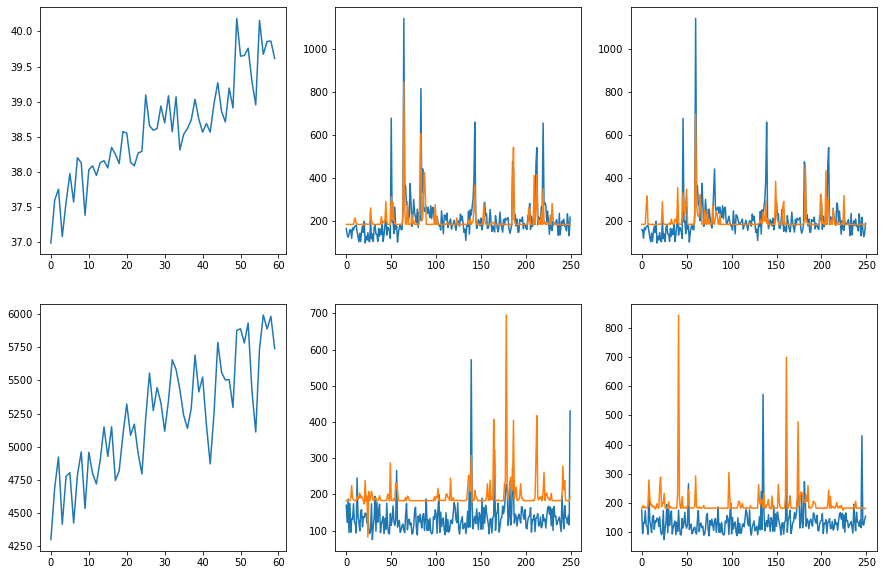

In [20]:

f,axes = plt.subplots(2,3,figsize=(15,10))
axes[0,0].plot(np.mean(np.abs(y_trues - y_preds),axis=(0,-1)))

axes[0,1].plot(y_trues[2500:2750,24,0])
axes[0,1].plot(y_preds[2500:2750,24,0])

axes[0,2].plot(y_trues[2500:2750,48,0])
axes[0,2].plot(y_preds[2500:2750,48,0])


axes[1,0].plot(np.mean(np.abs(y_trues - y_preds)**2,axis=(0,-1)))

axes[1,1].plot(y_trues[3500:3750,24,0])
axes[1,1].plot(y_preds[3500:3750,24,0])

axes[1,2].plot(y_trues[3500:3750,48,0])
axes[1,2].plot(y_preds[3500:3750,48,0])

### Radar and temperature

In [47]:
config_linear_w_temp = {
    'name': 'Ridge regression w temp',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : 2,
    'alpha' : 20,
}

# from Models import LinearModel
wandb.init(project=project, config=config_linear_w_temp)

def linear_model(alpha=0):
    return lambda : Ridge(alpha) 

n,f,*p = X1.shape

X1_tmp = X1.reshape(n,f,-1)
X2_tmp = X2.reshape(n,f,-1)
Y1_tmp = Y1.reshape(Y1.shape + (1,))
Y2_tmp = Y2.reshape(Y1.shape + (1,))

(history_linear_w_temp,models_linear_w_temp,iop_linear_w_temp) =\
        evaluate_model(model_constructor=linear_model(wandb.config['alpha']),
                       input_data=np.c_[X1_tmp,X2_tmp],
                       output_data = np.c_[Y1_tmp,Y2_tmp],
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       logger = wandb,
                       unfold_after_split = True
                       )

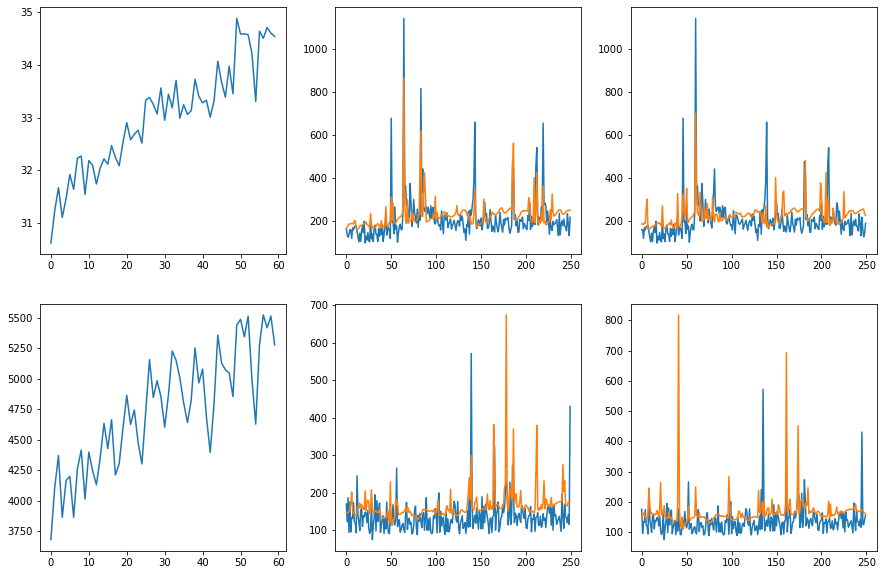

In [22]:
y_trues = np.r_[iop_linear_w_temp[3]['Y_train'],iop_linear_w_temp[3]['Y_val']].reshape(-1,pred_dist,2)
y_preds = np.r_[iop_linear_w_temp[3]['Y_train_pred'],iop_linear_w_temp[3]['Y_val_pred']].reshape(-1,pred_dist,2)

f,axes = plt.subplots(2,3,figsize=(15,10))
axes[0,0].plot(np.mean(np.abs(y_trues - y_preds),axis=(0,-1)))

axes[0,1].plot(y_trues[2500:2750,24,0])
axes[0,1].plot(y_preds[2500:2750,24,0])

axes[0,2].plot(y_trues[2500:2750,48,0])
axes[0,2].plot(y_preds[2500:2750,48,0])

axes[1,0].plot(np.mean(np.abs(y_trues - y_preds)**2,axis=(0,-1)))

axes[1,1].plot(y_trues[3500:3750,24,0])
axes[1,1].plot(y_preds[3500:3750,24,0])

axes[1,2].plot(y_trues[3500:3750,48,0])
axes[1,2].plot(y_preds[3500:3750,48,0])

In [49]:
config_linear_w_temp_and_ohe = {
    'name': 'Linear model w temp and pattern',
    'loss': loss,
    'cross_validation':cross_validation,
    'lag' : 2,
    'alpha' : 20,
}


# from Models import LinearModel
wandb.init(project=project, config=config_linear_w_temp_and_ohe)

def linear_model(alpha=0):
    return lambda : Ridge(alpha) 


n,f,*p = X1.shape

X1_tmp = X1.reshape(n,f,-1)
X2_tmp = X2.reshape(n,f,-1)
X3_tmp = X3.reshape(n,f,-1)
Y1_tmp = Y1.reshape(Y1.shape + (1,))
Y2_tmp = Y2.reshape(Y1.shape + (1,))


(history_linear_w_temp_and_ohe,models_linear_w_temp_and_ohe,iop_linear_w_temp_and_ohe) =\
        evaluate_model(model_constructor=linear_model(wandb.config['alpha']),
                       input_data=np.c_[X1_tmp,X2_tmp,X3_tmp],
                       output_data = np.c_[Y1_tmp,Y2_tmp],
                       thresholds = thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=False,
                       multiple_inputs=False,
                       unfold_after_split = True,
                   )



In [24]:
y_trues = np.r_[iop_linear_w_temp_and_ohe[3]['Y_train'],iop_linear_w_temp_and_ohe[3]['Y_val']].reshape(-1,pred_dist,2)
y_preds = np.r_[iop_linear_w_temp_and_ohe[3]['Y_train_pred'],iop_linear_w_temp_and_ohe[3]['Y_val_pred']].reshape(-1,pred_dist,2)

[]

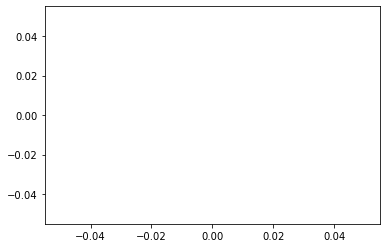

In [25]:
plt.plot()

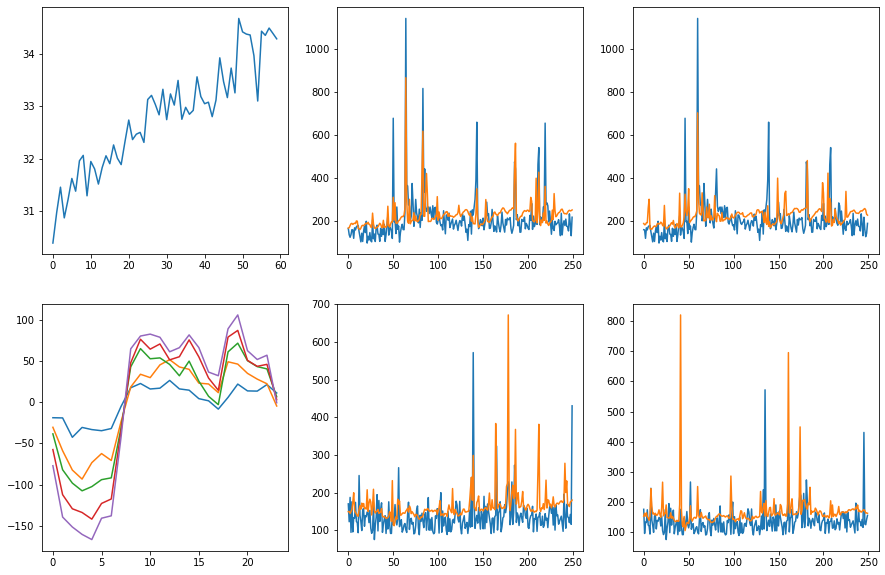

In [26]:
f,axes = plt.subplots(2,3,figsize=(15,10))
axes[0,0].plot(np.mean(np.abs(y_trues - y_preds),axis=(0,-1)))

axes[0,1].plot(y_trues[2500:2750,24,0])
axes[0,1].plot(y_preds[2500:2750,24,0])

axes[0,2].plot(y_trues[2500:2750,48,0])
axes[0,2].plot(y_preds[2500:2750,48,0])


axes[1,0].plot(models_linear_w_temp_and_ohe[0].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[1].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[2].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[3].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[4].coef_[0][-24:])

axes[1,1].plot(y_trues[3500:3750,24,0])
axes[1,1].plot(y_preds[3500:3750,24,0])

axes[1,2].plot(y_trues[3500:3750,48,0])
axes[1,2].plot(y_preds[3500:3750,48,0])

# Neural network models


### Common components

In [37]:
# def asdf(banana,orange):
#     print('banana:',banana)
#     print('orange:',orange)
    
# func_params = {'orange':'round','banana':'long'}
# asdf(**func_params)

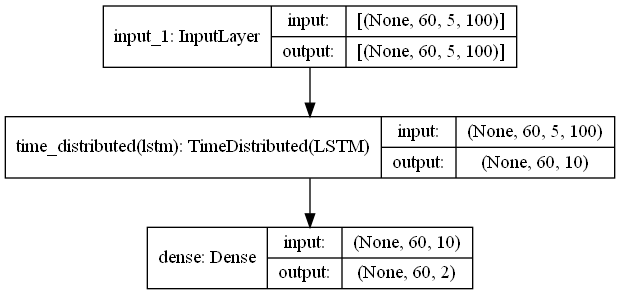

In [86]:
config_recurrent_simple = {
    'name': 'Simple recurrent model',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,

    # Tf stuff
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    'lag': 5,

    'rainfall_runoff': {
        'lstm': {
            'units': 10,
        },
        'dense_1': {
            'units': 2,
            'activation': 'linear'
        }
    },
    
    # Training
    'batch_size': 24*3,
    'epochs': 60,
    'learning_rate': {
        'inital_log': -1,
        'final_log': -3.5,
        'intervals': 100,
    },

}

wandb.init(project=project, config=config_recurrent_simple)


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def simple_recurrent_model():
    general_params = wandb.config
    rr_params = general_params['rainfall_runoff']
    
    tf.random.set_seed(general_params['random_seed'])
    # (n, 60, 3, 100)
    model = Sequential([Input((pred_dist,general_params['lag'], 100)),
                        TimeDistributed(LSTM(**rr_params['lstm'])),
                        Dense(**rr_params['dense_1']),],
                       'rain_gauge')

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])
    metrics = [tf.keras.metrics.MAE,
               tf.losses.MSE,
               tfp.stats.correlation]
    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=metrics)
    return model


tf.keras.utils.plot_model(simple_recurrent_model(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [52]:
n,f,*p = X1.shape

recurre_lag = wandb.config['lag']
X1_tmp = X1.reshape(n,f,-1)
Y12_tmp = np.c_[Y1[:,:,np.newaxis],Y2[:,:,np.newaxis]]
X1_tmp_2 = np.concatenate([np.zeros((n,recurre_lag-1,100)),X1_tmp],axis=1)
X1_tmp_3 = sliding_window_view(X1_tmp_2,(1,recurre_lag,100)).squeeze()
X1_tmp_3.shape

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    (history_recurr_simple,models_recurr_simple,iop_recurr_simple) =\
         evaluate_model(model_constructor=simple_recurrent_model,
                        input_data=X1_tmp_3,
                        output_data = Y12_tmp,
                        thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=False,
                        unfold_after_split = False,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                            ],
                          verbose=1
                          )

Epoch 1/60
12/12 [==============================] - 8s 87ms/step - loss: 29271.7090 - mean_absolute_error: 128.4099 - mean_squared_error: 29271.7051 - correlation: 0.0789 - val_loss: 32417.6113 - val_mean_absolute_error: 130.4648 - val_mean_squared_error: 32417.6113 - val_correlation: 0.3732
Epoch 2/60
12/12 [==============================] - 0s 16ms/step - loss: 26003.4648 - mean_absolute_error: 115.3981 - mean_squared_error: 26003.4629 - correlation: 0.3486 - val_loss: 29244.4180 - val_mean_absolute_error: 117.8252 - val_mean_squared_error: 29244.4199 - val_correlation: 0.2471
Epoch 3/60
12/12 [==============================] - 0s 16ms/step - loss: 23350.6016 - mean_absolute_error: 103.6946 - mean_squared_error: 23350.5977 - correlation: nan - val_loss: 26754.6406 - val_mean_absolute_error: 107.4233 - val_mean_squared_error: 26754.6387 - val_correlation: 0.2396
Epoch 4/60
12/12 [==============================] - 0s 16ms/step - loss: 21308.7695 - mean_absolute_error: 94.7026 - mean_sq

In [ ]:
y_trues = np.r_[iop_recurr_simple[3]['Y_train'],iop_recurr_simple[3]['Y_val']].reshape(-1,pred_dist,2)
y_preds = np.r_[iop_recurr_simple[3]['Y_train_pred'],iop_recurr_simple[3]['Y_val_pred']].reshape(-1,pred_dist,2)

f,axes = plt.subplots(2,3,figsize=(15,10))
axes[0,0].plot(np.mean(np.abs(y_trues - y_preds),axis=(0,-1)))

axes[0,1].plot(y_trues[2500:2750,24,0])
axes[0,1].plot(y_preds[2500:2750,24,0])

axes[0,2].plot(y_trues[2500:2750,48,0])
axes[0,2].plot(y_preds[2500:2750,48,0])


axes[1,0].plot(models_linear_w_temp_and_ohe[0].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[1].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[2].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[3].coef_[0][-24:])
axes[1,0].plot(models_linear_w_temp_and_ohe[4].coef_[0][-24:])

axes[1,1].plot(y_trues[3500:3750,24,0])
axes[1,1].plot(y_preds[3500:3750,24,0])

axes[1,2].plot(y_trues[3500:3750,48,0])
axes[1,2].plot(y_preds[3500:3750,48,0])

NameError: name 'iop_recurr_simple' is not defined

### Recurrent with temperature

### Simple conceptual model

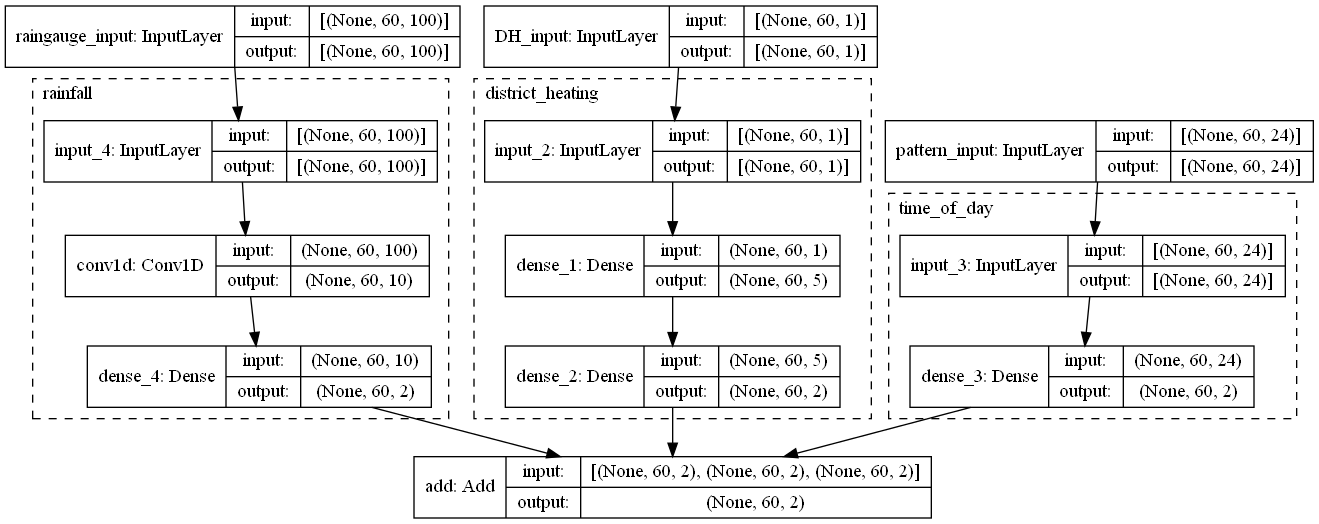

In [87]:
config_conceptual_simple = {
    'name': 'Simple conceptual model',
    'random_seed': 99,
    # 'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    
    'rainfall_runoff': {
        'lag': 2,
        'l2_regularization' : 20,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
    'weights' : [0.2,0.5,1,2,5,8,10,20]
}

wandb.init(project=project, config=config_conceptual_simple)
sample_weights_function = lambda x : sw_func(x, thresholds, wandb.config['weights'])

def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


# logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)


def conceptual_model_simple():
    general_params = wandb.config
    DH_params = general_params['district_heating']
    RR_params = general_params['rainfall_runoff']

    tf.random.set_seed(general_params['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((pred_dist,1,)),
        Dense(DH_params['dense_1'],
              DH_params['activation_1']),
        Dense(DH_params['dense_2'],
              DH_params['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input((pred_dist,general_params['pattern']['pattern_length'])),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  general_params['pattern']['pattern_constraint']))
    ], name='time_of_day')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential(
        [
            Input((pred_dist,100)),
            Conv1D(filters = 10,
                   kernel_size = RR_params['lag'],
                   padding = 'causal'),
        Dense(RR_params['dense_1'],
              RR_params['activation_1']),
        ], 'rainfall')
    
    # inputs
    Rainfall_runoff_input = Input(
        (pred_dist,100), name='raingauge_input')
    District_heating_input = Input((pred_dist,1,), name='DH_input')
    Daily_pattern_input = Input(
        (pred_dist,general_params['pattern']['pattern_length'],), name='pattern_input')


    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([Rainfall_runoff_input,
                            District_heating_input,
                            Daily_pattern_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss= lambda a,b : tf.losses.MSE(a,b) + tf.losses.MAE(a,b),
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)



In [184]:
n,f,*p = X1.shape

X1_tmp = X1.reshape(n,f,-1)
X2_tmp = X2.reshape(n,f,-1)
X3_tmp = X3.reshape(n,f,-1)

Y12_tmp = np.c_[Y1[:,:,np.newaxis],Y2[:,:,np.newaxis]]

# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_con_simple, models_con_simple, iop_con_simple) =\
         evaluate_model(model_constructor=conceptual_model_simple,
                        input_data=[
                              X1_tmp,
                              X2_tmp,
                              X3_tmp],
                        output_data=Y12_tmp,
                        thresholds = thresholds,
                        sample_weight_function=sample_weights_function,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                        ],
                        verbose = 1)


(829, 60, 2)
Epoch 1/120
35/35 [==============================] - 2s 15ms/step - loss: 149167.9062 - mean_absolute_error: 71.7947 - mean_squared_error: 13992.8701 - correlation: 0.2892 - val_loss: 25062.3184 - val_mean_absolute_error: 101.7935 - val_mean_squared_error: 24960.5254 - val_correlation: 0.3842
Epoch 2/120
35/35 [==============================] - 0s 4ms/step - loss: 79018.8281 - mean_absolute_error: 57.0903 - mean_squared_error: 9562.2676 - correlation: 0.3438 - val_loss: 9893.1777 - val_mean_absolute_error: 57.1383 - val_mean_squared_error: 9836.0400 - val_correlation: 0.3906
Epoch 3/120
35/35 [==============================] - 0s 4ms/step - loss: 77769.4609 - mean_absolute_error: 57.3921 - mean_squared_error: 9111.8867 - correlation: 0.3608 - val_loss: 10606.7822 - val_mean_absolute_error: 56.3927 - val_mean_squared_error: 10550.3906 - val_correlation: 0.3914
Epoch 4/120
35/35 [==============================] - 0s 4ms/step - loss: 75431.7656 - mean_absolute_error: 55.1088 

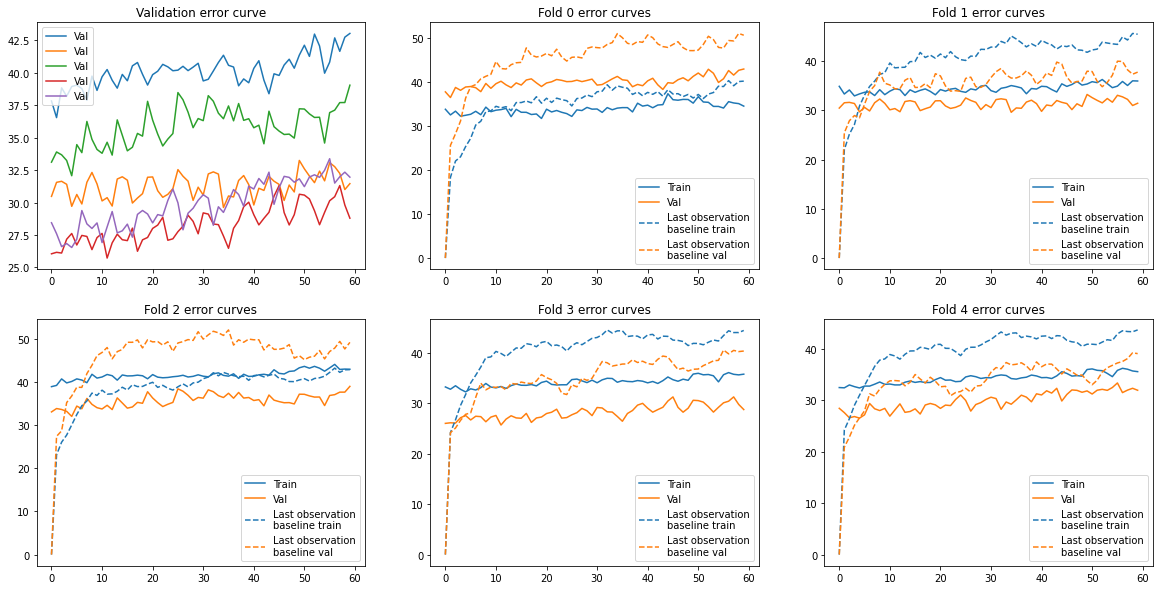

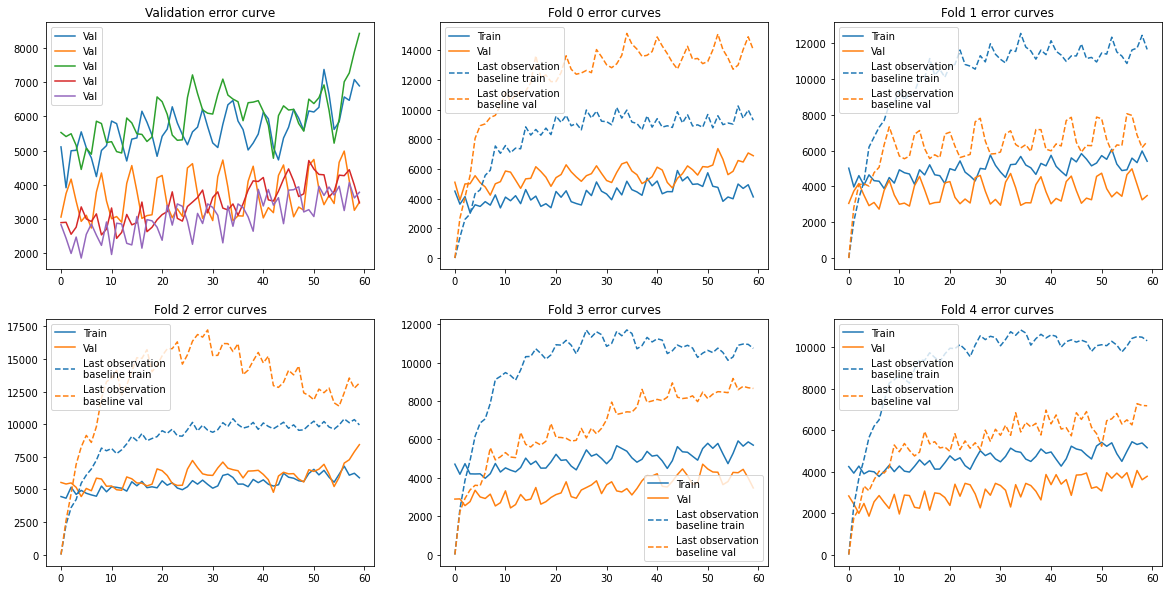

In [56]:
def error_profiles(iop,metric = 'mae'):
    f,axes = plt.subplots(2,3,figsize=(20,10))
    for key,ax in zip(iop,axes.ravel()[1:]):
        model_results = iop[key]
        Y_val = model_results['Y_val']
        Y_val_pred = model_results['Y_val_pred']
        Y_train = model_results['Y_train']
        Y_train_pred = model_results['Y_train_pred']
        
        # Error pattern
        training_resid = Y_train - Y_train_pred
        testing_resid = Y_val - Y_val_pred
        resid_last_value_val = Y_val - Y_val[:,[0],:]
        resid_last_value_train = Y_train - Y_train[:,[0],:]
        
        if metric == 'mae':
            training_error = np.mean(np.abs(training_resid),axis=(0,2))
            testing_error = np.mean(np.abs(testing_resid),axis=(0,2))
            baseline_error_val = np.mean(np.abs(resid_last_value_val),axis=(0,2))
            baseline_error_train = np.mean(np.abs(resid_last_value_train),axis=(0,2))
        if metric == 'mse':
            training_error = np.mean(np.power(training_resid,2),axis=(0,2))
            testing_error = np.mean(np.power(testing_resid,2),axis=(0,2))
            baseline_error_val = np.mean(np.power(resid_last_value_val,2),axis=(0,2))
            baseline_error_train = np.mean(np.power(resid_last_value_train,2),axis=(0,2))
        
        line1 = ax.plot(training_error,label = 'Train')
        line2 = ax.plot(testing_error,label = 'Val')
        
        # Baseline error
        ax.plot(baseline_error_train,label = 'Last observation\nbaseline train',
                    linestyle='--', color = line1[0].get_color())    
        ax.plot(baseline_error_val,label = 'Last observation\nbaseline val',
                    linestyle='--', color = line2[0].get_color())
        
        
        ax.legend()
        ax.set_title(f'Fold {key} error curves')
        
        
        axes[0,0].plot(testing_error,label = 'Val')
    axes[0,0].legend()
    axes[0,0].set_title('Validation error curve')
    plt.show()
    
error_profiles(iop_con_simple,'mae')
error_profiles(iop_con_simple,'mse')

### Conceptual model with recurrent rainfall runoff

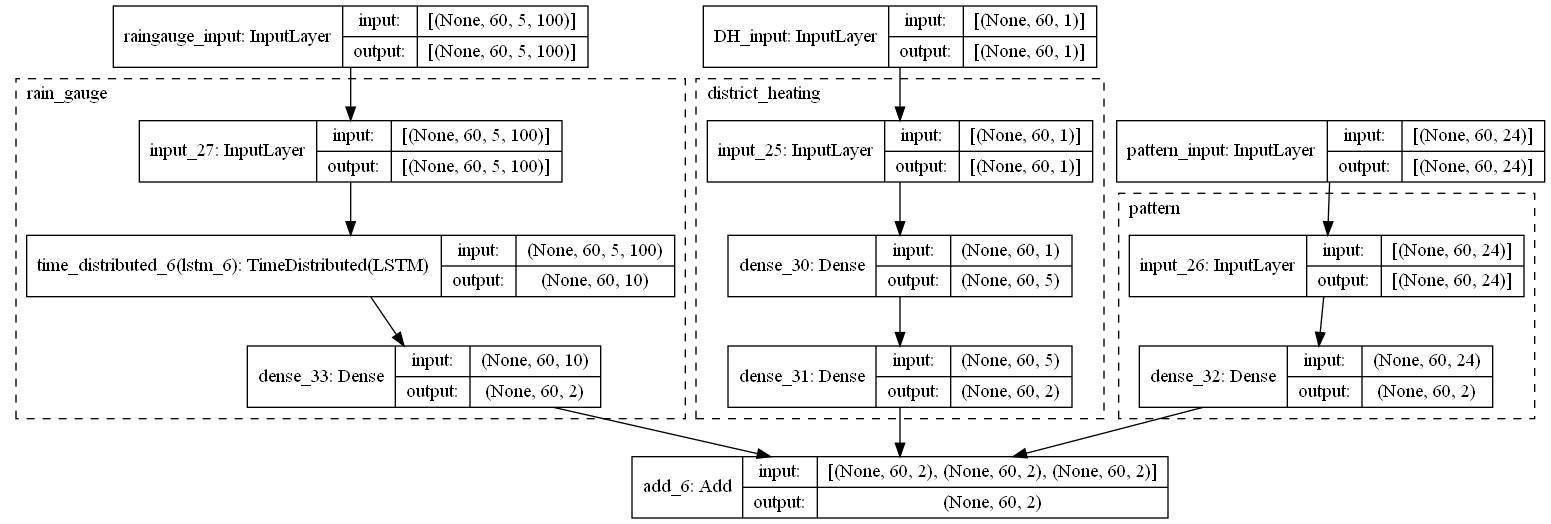

In [57]:
lag = 12
config_conceptual_recurrent = {
    'name': 'Conceptual model with recurrent rainfall-runoff',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    'lag': 5,

    'rainfall_runoff': {
        'lstm': {
            'units': 10,
        },
        'dense_1': {
            'units': 2,
            'activation': 'linear'
        }
    },
    
    # Training
    'batch_size': 24,
    'epochs': 150,
    'learning_rate': {
        'inital_log': 0,
        'final_log': -3.5,
        'intervals': 100,
    },

}
wandb.init(project=project, config=config_conceptual_recurrent)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def conceptual_model_recurrent():
    general_params = wandb.config
    DH_params = general_params['district_heating']
    rr_params = general_params['rainfall_runoff']
    
    tf.random.set_seed(99)

    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((pred_dist,1,)),
        Dense(DH_params['dense_1'],
              DH_params['activation_1']),
        Dense(DH_params['dense_2'],
              DH_params['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input((pred_dist,general_params['pattern']['pattern_length'])),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  general_params['pattern']['pattern_constraint']))
    ], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([Input((pred_dist,general_params['lag'], 100)),
                        TimeDistributed(LSTM(**rr_params['lstm'])),
                        Dense(**rr_params['dense_1']),],
                       'rain_gauge')
    

    Rainfall_runoff_input = Input(
        (pred_dist,general_params['lag'], 100), name='raingauge_input')
    District_heating_input = Input((pred_dist,1,), name='DH_input')
    Daily_pattern_input = Input(
        (pred_dist,general_params['pattern']['pattern_length'],), name='pattern_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([Rainfall_runoff_input,
                            District_heating_input,
                            Daily_pattern_input],
                           combined_output)

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model

tf.keras.utils.plot_model(conceptual_model_recurrent(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [58]:
X1_tmp_3.shape,X2_tmp.shape,X3_tmp.shape

((4964, 60, 5, 100), (4964, 60, 1), (4964, 60, 24))

In [59]:
n,f,*p = X1.shape

recurre_lag = wandb.config['lag']
X1_tmp = X1.reshape(n,f,-1)
Y12_tmp = np.c_[Y1[:,:,np.newaxis],Y2[:,:,np.newaxis]]
X1_tmp_2 = np.concatenate([np.zeros((n,recurre_lag-1,100)),X1_tmp],axis=1)
X1_tmp_3 = sliding_window_view(X1_tmp_2,(1,recurre_lag,100)).squeeze()

X2_tmp = X2.reshape(n,f,-1)
X3_tmp = X3.reshape(n,f,-1)

Y12_tmp = np.c_[Y1[:,:,np.newaxis],Y2[:,:,np.newaxis]]

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    (history_dict_conceptual_recurrent,
     models_conceptual_recurrent, iop_conceptual_recurrent) =\
          evaluate_model(model_constructor=conceptual_model_recurrent,
                        input_data=[
                              X1_tmp_3,
                              X2_tmp,
                              X3_tmp],
                        output_data=Y12_tmp,
                        thresholds = thresholds,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            # logging_callback
                        ],
                        verbose = 1)

Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 3s 32ms/step - loss: 11203.2598 - mean_absolute_error: 59.0937 - mean_squared_error: 11203.2607 - correlation: -0.2198 - val_loss: 9408.8330 - val_mean_absolute_error: 50.5811 - val_mean_squared_error: 9408.8311 - val_correlation: 0.2501
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 1s 15ms/step - loss: 7139.5312 - mean_absolute_error: 40.4669 - mean_squared_error: 7139.5308 - correlation: 0.1288 - val_loss: 8906.0625 - val_mean_absolute_error: 44.9222 - val_mean_squared_error: 8906.0654 - val_correlation: 0.2173
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.9218207178777467.
35/35 [==============================] - 0s 13ms/step - loss: 6420.6196 - mean_absolute_error: 37.9971 - mean_squared_error: 6420.6187 - correlation: 0.3379 - val_loss: 8681.4121 - val_mean_absolu

# Basic NN

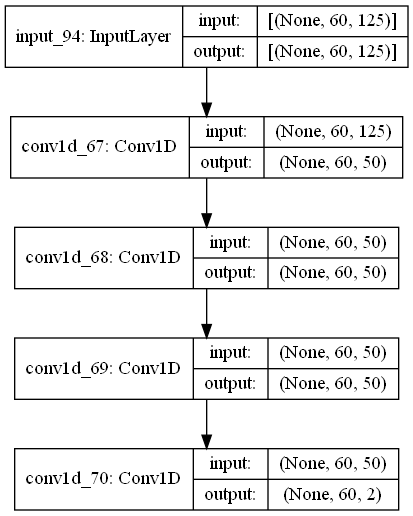

In [134]:
lag = 2

early_stopper_params_tmp = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 50,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
}

config_basic_NN = {
    'name': 'Basic_NN',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params_tmp,

    # model
    'lag': lag,

    'NN': {
        'Conv1D_0': {
            'filters': 20,
            'kernel_size': lag,
            # 'kernel_regularizer': tf.keras.regularizers.l2(10.),
            'activation': 'relu',
            'padding': 'causal',
        },
        'Conv1D_1': {
            'filters': 20,
            'kernel_size': lag,
            # 'kernel_regularizer': tf.keras.regularizers.l2(10.),
            'activation': 'relu',
            'padding': 'causal',
        },
        'Conv1D_2': {
            'filters': 20,
            'kernel_size': lag,
            # 'kernel_regularizer': tf.keras.regularizers.l2(10.),
            'activation': 'relu',
            'padding': 'causal',
        },
        'Conv1D_3': {
            'filters': 2,
            'kernel_size': lag,
            'activation': 'linear',
            'padding': 'causal',
        },

        'dropout_0': {
            'rate': 0.3
        },

        'dropout_1': {
            'rate': 0.3
        },

    },
    # Training
    'batch_size': 24,
    'epochs': 150,
    'learning_rate': {
        'inital_log': 0,
        'final_log': -3.5,
        'intervals': 100,
    },

}

wandb.init(project='custom_CSI_table_test', config=config_basic_NN)
logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])


def basic_NN():
    general_params = wandb.config
    NN_params = general_params['NN']
    tf.random.set_seed(99)

    # Rainfall runoff only input: rain-gauge
    model = Sequential([
        Input((pred_dist, 125)),
        # Conv1D(**NN_params['Conv1D_0'],
                # kernel_regularizer =tf.keras.regularizers.l2(1.),
                # ),
        # Dropout(**NN_params['dropout_0']),
        # Conv1D(**NN_params['Conv1D_1'],
                # kernel_regularizer =tf.keras.regularizers.l2(1.),
                # ),
        # Dropout(**NN_params['dropout_1']),
        # Conv1D(**NN_params['Conv1D_2'],
                # kernel_regularizer =tf.keras.regularizers.l2(1.),
                # ),
        Conv1D(**NN_params['Conv1D_3']),
    ])

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(basic_NN(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


n, f, *p = X1.shape

X1_tmp = X1.reshape(n, f, -1)
X2_tmp = X2.reshape(n, f, -1)
X3_tmp = X3.reshape(n, f, -1)
Y1_tmp = Y1.reshape(Y1.shape + (1,))
Y2_tmp = Y2.reshape(Y1.shape + (1,))


with tf.device('/gpu:0'):
    # with tf.device('/cpu:0'):
    (history_basic_NN, models_basic_NN, iop_basic_NN) =\
        evaluate_model(model_constructor=basic_NN,
                       input_data=np.c_[X1_tmp, X2_tmp, X3_tmp],
                       output_data=np.c_[Y1_tmp, Y2_tmp],
                       thresholds=thresholds,
                       fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                       folds=wandb.config['cross_validation']['folds'],
                       tensorflow_model=True,
                       multiple_inputs=False,
                       unfold_after_split=False,

                       # Kwargs
                       batch_size=wandb.config['batch_size'],
                       epochs=wandb.config['epochs'],
                       shuffle=True,
                       callbacks=[
                           lr_scheduler,
                           early_stopper,
                           logging_callback
                       ],
                       verbose=1
                       )

Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 1s 13ms/step - loss: 9632.4160 - mean_absolute_error: 55.3594 - mean_squared_error: 9632.4150 - correlation: 0.4241 - val_loss: 8768.3076 - val_mean_absolute_error: 46.0550 - val_mean_squared_error: 8768.3086 - val_correlation: 0.3481
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 1.0.
35/35 [==============================] - 0s 6ms/step - loss: 6858.0742 - mean_absolute_error: 40.1991 - mean_squared_error: 6858.0747 - correlation: 0.6103 - val_loss: 8567.2363 - val_mean_absolute_error: 45.7709 - val_mean_squared_error: 8567.2373 - val_correlation: 0.3252
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.9218207178777467.
35/35 [==============================] - 0s 7ms/step - loss: 6693.6479 - mean_absolute_error: 39.1538 - mean_squared_error: 6693.6479 - correlation: 0.6411 - val_loss: 8419.3359 - val_mean_absolute_er

KeyboardInterrupt: 

# Simple conseptual with sigmoid


In [207]:


tmp_weights = np.linspace(0,1000,100*2).reshape(100,2)
tmp_weights = np.linspace(0,1000,100*60*2).reshape(100,60,2)
sample_weights_function = lambda x : sw_func(x, thresholds,  [0.2,0.5,1,2,5,8,10,15])
sample_weights_function(tmp_weights)

(100, 60, 2)


array([[ 0.4,  0.4,  0.4, ...,  0.4,  0.4,  0.4],
       [ 0.4,  0.4,  0.4, ...,  0.4,  0.4,  0.4],
       [ 0.4,  0.4,  0.4, ...,  0.7,  0.7,  0.7],
       ...,
       [25. , 25. , 25. , ..., 25. , 25. , 25. ],
       [25. , 25. , 25. , ..., 25. , 25. , 25. ],
       [25. , 25. , 25. , ..., 25. , 25. , 25. ]])

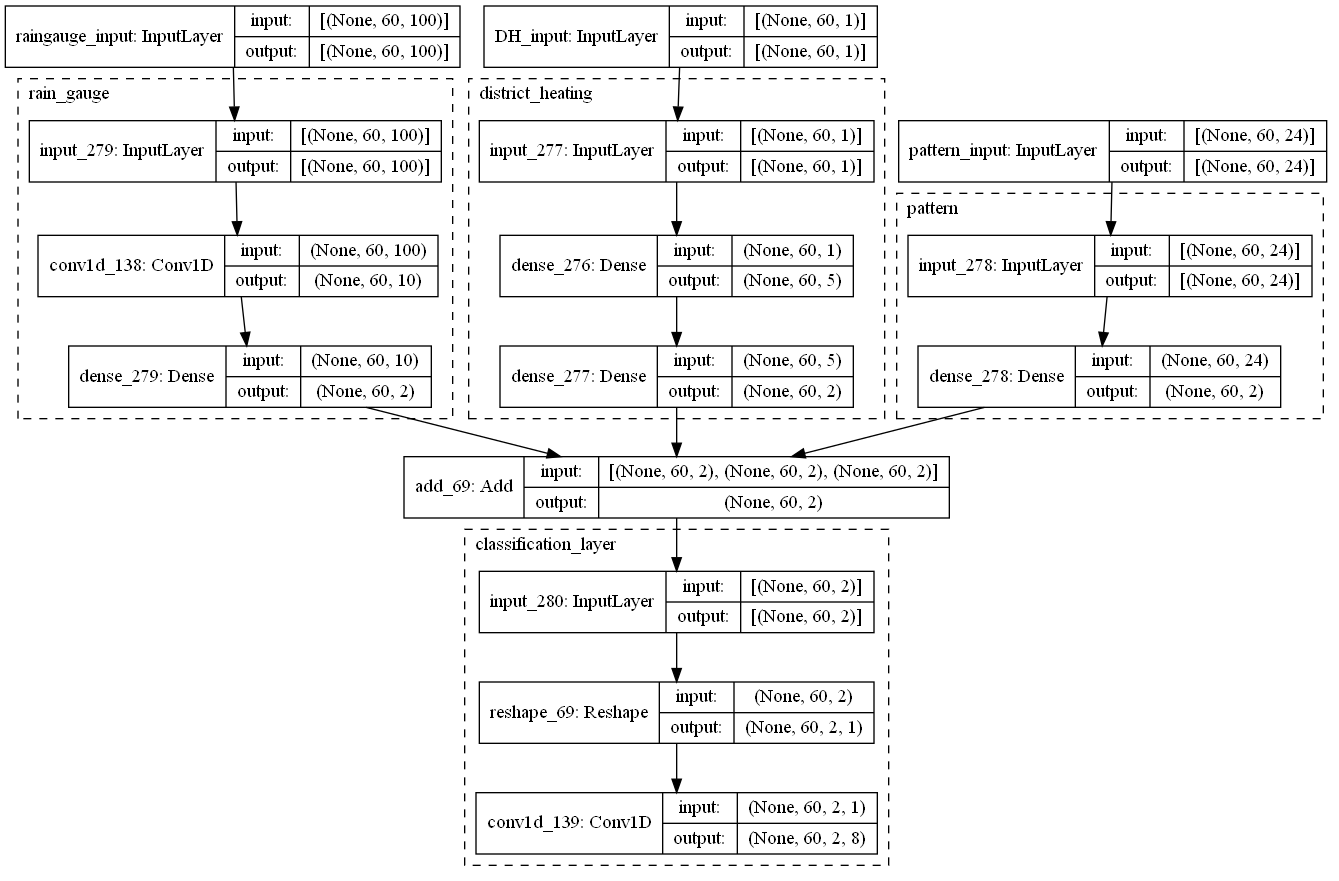

In [281]:
config_conceptual_classification_simple = {
    'name': 'Simple conceptual_classification model with sigmoid',
    'random_seed': 99,
    'loss': loss,
    'cross_validation': cross_validation,
    'optimizer': optimizer_params,
    'early_stopper': early_stopper_params,
    # model
    'district_heating': district_heating,
    'pattern': pattern,
    
    'rainfall_runoff': {
        'lag': 2,
        'l2_regularization' : 20,
        'dense_1': 2,
        'activation_1': 'linear',
    },
    # Training
    'batch_size': 24,
    'epochs': 120,
    'learning_rate': {
        'inital_log': -0.5,
        'final_log': -4,
        'intervals': 100,
    },
    # 'weights' : [0.2,0.5,1,2,5,8,10,15]
    'weights' : [1,1,1,1,1,1,1,1]
}

wandb.init(project=project, config=config_conceptual_classification_simple)

def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(
    **wandb.config['early_stopper'])

# wandb.init(project=project, config=config)
n_classes = thresholds.shape[1]

def conceptual_classification_model_simple():
    general_params = wandb.config
    DH_params = general_params['district_heating']
    RR_params = general_params['rainfall_runoff']

    tf.random.set_seed(general_params['random_seed'])
    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((pred_dist,1,)),
        Dense(DH_params['dense_1'],
              DH_params['activation_1']),
        Dense(DH_params['dense_2'],
              DH_params['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input((pred_dist,general_params['pattern']['pattern_length'])),
        Dense(2,
              activation='linear',
              use_bias=False,
              kernel_constraint=tf.keras.constraints.get(
                  general_params['pattern']['pattern_constraint']))
    ], name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential(
        [
            Input((pred_dist,100)),
            Conv1D(filters = 10,
                   kernel_size = RR_params['lag'],
                   padding = 'causal'),
        Dense(RR_params['dense_1'],
              RR_params['activation_1']),
        ], 'rain_gauge')
    
    # sigmoid output
    classification_layer = Sequential([
        Input((pred_dist,2)),
        Reshape((pred_dist,2,1)),
        Conv1D(n_classes,1,activation = 'sigmoid'),
        # Activation('sigmoid')
        ], 'classification_layer')
    
    # inputs
    Rainfall_runoff_input = Input(
        (pred_dist,100), name='raingauge_input')
    District_heating_input = Input((pred_dist,1,), name='DH_input')
    Daily_pattern_input = Input(
        (pred_dist,general_params['pattern']['pattern_length'],), name='pattern_input')


    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    classification_output = classification_layer(combined_output)
    
    model = tf.keras.Model([Rainfall_runoff_input,
                            District_heating_input,
                            Daily_pattern_input],
                           classification_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(general_params['optimizer'])

    # model.compile(optimizer=optimizer,
    #               loss= lambda a,b : tf.losses.MSE(a,b) + tf.losses.MAE(a,b),
    #               metrics=[tf.keras.metrics.MAE,
    #                        tf.losses.MSE, tfp.stats.correlation]
    #               )
    model.compile(optimizer=optimizer,
                  loss= tf.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_classification_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)



In [282]:
n,f,*p = X1.shape

X1_tmp = X1.reshape(n,f,-1)
X2_tmp = X2.reshape(n,f,-1)
X3_tmp = X3.reshape(n,f,-1)

Y12_tmp = np.c_[Y1[:,:,np.newaxis],Y2[:,:,np.newaxis]]

Y12_tmp_cls = np.zeros(Y12_tmp.shape + (8,))
for i,(t1,t2) in enumerate(thresholds.T):
    Y12_tmp_cls[:,:,0,i] = (Y12_tmp[:,:,0] > t1)*1
    Y12_tmp_cls[:,:,1,i] = (Y12_tmp[:,:,1] > t2)*1
    
    
sample_weights_function = lambda x : sw_func(x, thresholds, wandb.config['weights'],classification=True)

# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_con_simple, models_con_simple, iop_con_simple) =\
         evaluate_model(model_constructor=conceptual_classification_model_simple,
                        input_data=[
                              X1_tmp,
                              X2_tmp,
                              X3_tmp],
                        output_data = Y12_tmp_cls,
                        thresholds = thresholds,
                        sample_weight_function=sample_weights_function,
                        fn_crossval=wandb.config['cross_validation']['fn_kfold'],
                        folds=wandb.config['cross_validation']['folds'],
                        tensorflow_model=True,
                        multiple_inputs=True,
                        classification=True,
                        # Kwargs
                        batch_size=wandb.config['batch_size'],
                        epochs=wandb.config['epochs'],
                        shuffle=True,
                        callbacks=[
                            lr_scheduler,
                            early_stopper,
                            logging_callback
                        ],
                        verbose = 1,)


(829, 60, 2, 8) True
weights.shape (829, 60, 2, 8)
Epoch 1/120
35/35 [==============================] - 1s 14ms/step - loss: 0.2219 - mean_absolute_error: 0.1216 - mean_squared_error: 0.0622 - correlation: nan - val_loss: 0.2248 - val_mean_absolute_error: 0.1146 - val_mean_squared_error: 0.0638 - val_correlation: nan
Epoch 2/120
19/35 [===============>..............] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.0999 - mean_squared_error: 0.0519 - correlation: na

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


35/35 [==============================] - 0s 5ms/step - loss: 0.1739 - mean_absolute_error: 0.0999 - mean_squared_error: 0.0517 - correlation: nan - val_loss: 0.2022 - val_mean_absolute_error: 0.1100 - val_mean_squared_error: 0.0608 - val_correlation: nan
Epoch 3/120
35/35 [==============================] - 0s 5ms/step - loss: 0.1626 - mean_absolute_error: 0.0993 - mean_squared_error: 0.0496 - correlation: nan - val_loss: 0.1894 - val_mean_absolute_error: 0.1089 - val_mean_squared_error: 0.0565 - val_correlation: nan
Epoch 4/120
35/35 [==============================] - 0s 4ms/step - loss: 0.1614 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0485 - correlation: nan - val_loss: 0.1820 - val_mean_absolute_error: 0.1053 - val_mean_squared_error: 0.0542 - val_correlation: nan
Epoch 5/120
35/35 [==============================] - 0s 4ms/step - loss: 0.1554 - mean_absolute_error: 0.0940 - mean_squared_error: 0.0467 - correlation: nan - val_loss: 0.1769 - val_mean_absolute_error: 0.1011 

In [283]:
# iop_con_simple[1]['sample_weights']

# ROC curve for max threshold

In [284]:
from sklearn.metrics import roc_curve, auc

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


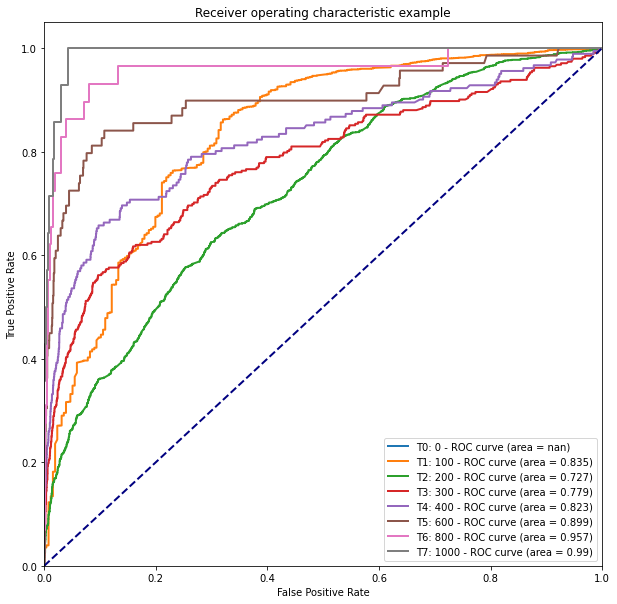

In [285]:
prediction_distance = 24
sensor = 0

plt.figure(figsize=(10,10))

fpr,tpr,roc_auc = dict(),dict(),dict()
for thresh in range(8):
    t_val = thresholds[sensor,thresh]
    
    y_preds = []
    y_trues = []
    
    for fold in range(5):
        y_pred = iop_con_simple[fold]['Y_val_pred'][:,prediction_distance,sensor,thresh]
        y_true = iop_con_simple[fold]['Y_val'][:,prediction_distance,sensor,thresh]
        y_preds.append(y_pred)
        y_trues.append(y_true)
        
    y_preds = np.concatenate(y_preds)
    y_trues = np.concatenate(y_trues)

    fpr[thresh], tpr[thresh], _ = roc_curve(y_trues.reshape(-1, 1), y_preds.reshape(-1, 1))
    roc_auc[thresh] = auc(fpr[thresh], tpr[thresh]).round(3)
    # roc_auc[thresh]
    plt.plot(fpr[thresh],    tpr[thresh],  lw=2,
            label=f"T{thresh}: {t_val} - ROC curve (area = {roc_auc[thresh]})")


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


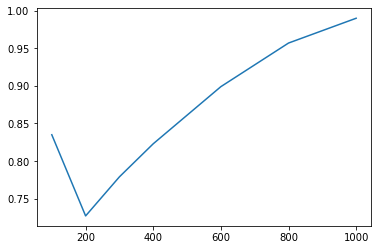

In [287]:
plt.plot(thresholds[0],roc_auc.values())

In [166]:
y_pred = iop_con_simple[fold]['Y_val_pred']
y_true = iop_con_simple[fold]['Y_val']

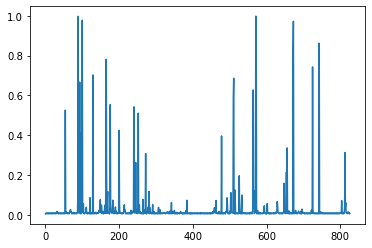

In [176]:
plt.plot(y_pred[:,24,0,4])

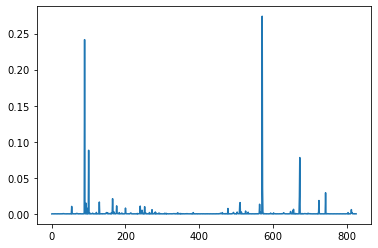

In [171]:
plt.plot(y_pred[:,24,0,7])


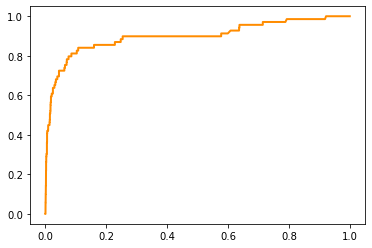

In [153]:
# Compute ROC curve and ROC area for each class



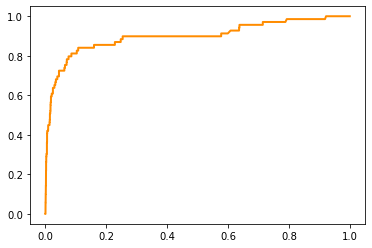

In [141]:
# np.sum(y_true)

In [134]:
# np.any(y_true == 1)

In [126]:
# plt.plot(fpr)

In [135]:
fpr, tpr

(array([0.        , 0.00121065, 0.25423729, 0.2566586 , 0.27239709,
        0.2748184 , 0.34140436, 0.34382567, 0.35108959, 0.3535109 ,
        0.3559322 , 0.36077482, 0.36803874, 0.3716707 , 0.37409201,
        0.37530266, 0.38135593, 0.39467312, 0.40193705, 0.41162228,
        0.41404358, 0.46004843, 0.5157385 , 0.5157385 , 0.51694915,
        0.52058111, 0.52300242, 0.52663438, 0.52905569, 0.53631961,
        0.53874092, 0.54600484, 0.56053269, 0.56416465, 0.60774818,
        0.61138015, 0.69249395, 0.69491525, 0.69612591, 0.69854722,
        0.69975787, 0.70460048, 0.70823245, 0.7094431 , 0.71670702,
        0.72033898, 0.73244552, 0.77845036, 0.78813559, 0.79661017,
        0.79782082, 0.80024213, 0.87651332, 0.87893462, 0.88256659,
        0.88498789, 0.88619855, 0.88861985, 0.89225182, 0.89709443,
        0.90193705, 0.9031477 , 0.91283293, 0.9188862 , 0.92857143,
        0.98547215, 0.99394673, 1.        ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

ModuleNotFoundError: No module named 'helpers'